In [1]:
import gquant
import abupy
import QUANTAXIS as QA
import gquant.jupyter_helper
gquant.jupyter_helper.init()

Expand macros in C:\Users\GuQiang\Anaconda3\envs\stock_ai\lib\site-packages\macropy\core\hquotes.py
Finding macros in 'macropy.core.hquotes'
Importing macros from 'macropy.core.quotes' into 'macropy.core.hquotes'
Expand macros in C:\Users\GuQiang\Anaconda3\envs\stock_ai\lib\site-packages\macropy\core\quotes.py
Finding macros in 'macropy.core.quotes'
Expand macros in C:\Users\GuQiang\Anaconda3\envs\stock_ai\lib\site-packages\macropy\core\failure.py
Finding macros in 'macropy.core.failure'
Importing macros from 'macropy.core.hquotes' into 'macropy.core.failure'


# 原始数据

In [2]:
# 原始未复权数据
ori_data_df = gquant.pd.read_csv('300378_daily.csv', 
                                 encoding='utf-8', 
                                 parse_dates=[0], 
                                 dtype={'code': str}).set_index(['date', 'code'])
ori_data = QA.QAData.QA_DataStruct_Stock_day(ori_data_df)
# 前复权数据
ori_data_df_qfq = ori_data.to_qfq().data

# 数据初始化

In [3]:
class LocalDataAPI(abupy.MarketBu.ABuDataBase.StockBaseMarket,
                   abupy.MarketBu.ABuDataBase.SupportMixin):
    def _support_market(self):
        """声明数据源支持A股"""
        return [abupy.EMarketTargetType.E_MARKET_TARGET_CN]

    def kline(self, n_folds=2, start=None, end=None, fq='01'):
        df = ori_data_df_qfq.copy()
        df['pre_close'] = df['close'].shift()
        df['date'] = df.index.get_level_values(0)
        df['date'] = df['date'].dt.strftime('%Y%m%d').apply(
            lambda x: abupy.ABuDateUtil.date_str_to_int(x))
        df.index = df.index.droplevel(1)
        df.index.name = 'dt'
        df['date_week'] = df.index.dayofweek
        return df

    def minute(self, n_fold=5, *args, **kwargs):
        """分钟k线接口"""
        raise NotImplementedError('QAApi minute NotImplementedError!')

In [4]:
abupy.env.g_market_target = abupy.env.EMarketTargetType.E_MARKET_TARGET_CN
# 所有任务数据强制网络更新
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET
# 使用QUATAXIS本地数据作为数据源
abupy.env.g_private_data_source = LocalDataAPI

In [5]:
# symbol = abupy.ABuMarket.code_to_symbol('sz300378')
# df = LocalDataAPI(symbol).kline()
# df

In [6]:
from abupy.IndicatorBu.ABuNDAtr import calc_atr
from QUANTAXIS.QAIndicator.talib_series import SMA


class KLManager(abupy.AbuKLManager):
    def _fetch_pick_time_kl_pd(self, target_symbol):
        data = abupy.MarketBu.ABuSymbolPd.make_kl_df(target_symbol)
        if not data.empty:
            high = data['high']
            low = data['low']
            pre_close = data['pre_close']
            data['atr14'] = calc_atr(high, low, pre_close, 14)
            data['atr21'] = calc_atr(high, low, pre_close, 21)
            for ma in [10,20]:
                data['ma{}'.format(ma)] = SMA(data.close,timeperiod=ma)
        result = data[self.benchmark.start:self.benchmark.end]
        result.name = data.name
        return result

## 初始化数据读取示例

In [7]:
# 沪深300指数
benchmark=gquant.abupy.TradeBu.ABuBenchmark.AbuBenchmark(benchmark='000300', start='2014-01-01', end='2019-12-31')
# 资金管理。使用默认的手续费计算方法
capital=gquant.abupy.TradeBu.ABuCapital.AbuCapital(10000,benchmark,)

In [8]:
# abupy.MarketBu.ABuSymbolPd.make_kl_df('300378')

# 简单测试

**问题**： 所有简单测试都并不准确，仅做示例参考。因为：

1. 以当日收盘价作为判断依据的同时，以当日作为建仓或清仓标准是不合理的。
2. 没有考虑交易手续费

In [9]:
def simple_test(data,**kwargs):
    """
    
    Args:
        cols1 (list): 第一个y轴的标签集合。默认为`['close']`。
        cols2 (list): 第二个y轴的标签集合。默认为`[]`。第二个轴会显示为虚线。
    """
    fig, ax1 = gquant.plt.subplots()
    # 绘制完整布林带买卖盈亏示例
    data[kwargs.pop('cols1',['close'])].plot(figsize=(50,10),ax=ax1)
    if 'buy' in data:
        ax1.vlines(data[data['buy'] == 1].index,0,data[data['buy'] == 1]['close'].max(),colors='r', linestyle=':')
    if 'sell' in data:
        ax1.vlines(data[data['sell'] == 1].index,0,data[data['buy'] == 1]['close'].max(), colors='g',linestyle=':')
    simple_profit=[]#盈亏示例
    record=[]#成交明细
    if 'buy' in data and 'sell' in data:
        last_buy=[]
        for index,row in data.iterrows():
            if row['buy']==1:
                last_buy.append(index)
                continue
            if row['sell']==1:
                while last_buy:
                    b=last_buy.pop(0)
                    buy_close=data['close'][b]
                    sell_close=data['close'][index]
                    record.append(gquant.pd.DataFrame(
                    {
                        'bd':[b],#买入日期
                        'bp':[buy_close],#买入价格
                        'sd':[index],#卖出日期
                        'sp':[sell_close],#卖出价格
                        'h':[len(data['close'][b:index])],#持仓天数
                        'sc':[100]#模拟买入100股
                    }))
                    pf=(sell_close-buy_close)/buy_close#交易盈亏率
                    data.loc[b:index,'close'].plot.area(ax=ax1,color='g' if sell_close<=buy_close else 'r', alpha=0.5)
                    ax1.annotate('{:.2f}'.format(pf),(b,buy_close), fontsize=16)
                    simple_profit.append(pf)
        record=gquant.pd.concat(record)
        record['profit']=record.apply(lambda x:(x.sp-x.bp)*x.sc,axis=1)
    cols2=kwargs.pop('cols2',[])
    if cols2:
        ax2 = ax1.twinx()
        data[cols2].plot(ax=ax2,ls='--')
        ax2.tick_params(axis='y')
    fig.tight_layout()
    gquant.plt.show()
    
    if simple_profit:
        # 绘制单次盈亏比率柱状图
        simple_profit=gquant.pd.Series(simple_profit)
        simple_profit.round(2).sort_index().plot(kind='bar',figsize=(5,3),title='单次盈亏比率')
        gquant.plt.show()
    
        # 绘制盈亏占比饼图
        gquant.pd.Series(gquant.np.sign(simple_profit)).value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(5,3),title='盈亏次数占比')
        gquant.plt.show()
        
        s= gquant.pd.Series(
            {
                '盈利交易平均盈利比率':simple_profit[simple_profit > 0].mean(),
                '最大盈利比率':simple_profit.max(),
                '亏损交易平均亏损比率':simple_profit[simple_profit <= 0].mean(),
                '最大亏损比率':simple_profit.min(),
                '平均盈亏比率':simple_profit.mean(),
                '交易次数':simple_profit.count(),
                '总天数':len(data),
                '平均持仓天数':record['h'].mean(),
                'R(平均利润/平均损失)':abs(record['profit'].mean()) / abs(record[record['profit']<=0]['profit'].mean())
            })
        return s
    return gquant.pd.Series()

## 短期均线穿越长期均线（双均线）

- 短期均线上穿长期均线（买入）
- 长期均线上穿短期均线（卖出）

* 短期均线：10日
* 长期均线：20日

测试了2014~2019年之间的数据。

|                                         |   盈利交易平均盈利比率 |   最大盈利比率 |   亏损交易平均亏损比率 |   最大亏损比率 |   平均盈亏比率 |   交易次数 |   总天数 |   平均持仓天数 |   R(平均利润/平均损失) |
|:----------------------------------------|-----------------------:|---------------:|-----------------------:|---------------:|---------------:|-----------:|---------:|---------------:|-----------------------:|
| 简单测试-短期均线穿越长期均线（双均线） |               0.197792 |         0.8529 |             -0.0469693 |      -0.109115 |      0.0642859 |         33 |     1442 |        20.8485 |                2.25487 |

问题：[简单测试的问题说明](#%E7%AE%80%E5%8D%95%E6%B5%8B%E8%AF%95)

In [10]:
simple_data=KLManager(benchmark,capital).get_pick_time_kl_pd('300378')
# 收盘价上穿布林带上轨
simple_data['buy']=QA.QAIndicator.CROSS(simple_data['ma10'],simple_data['ma20'])
# 收盘价下穿布林带中轨
simple_data['sell']=QA.QAIndicator.CROSS(simple_data['ma20'],simple_data['ma10'])

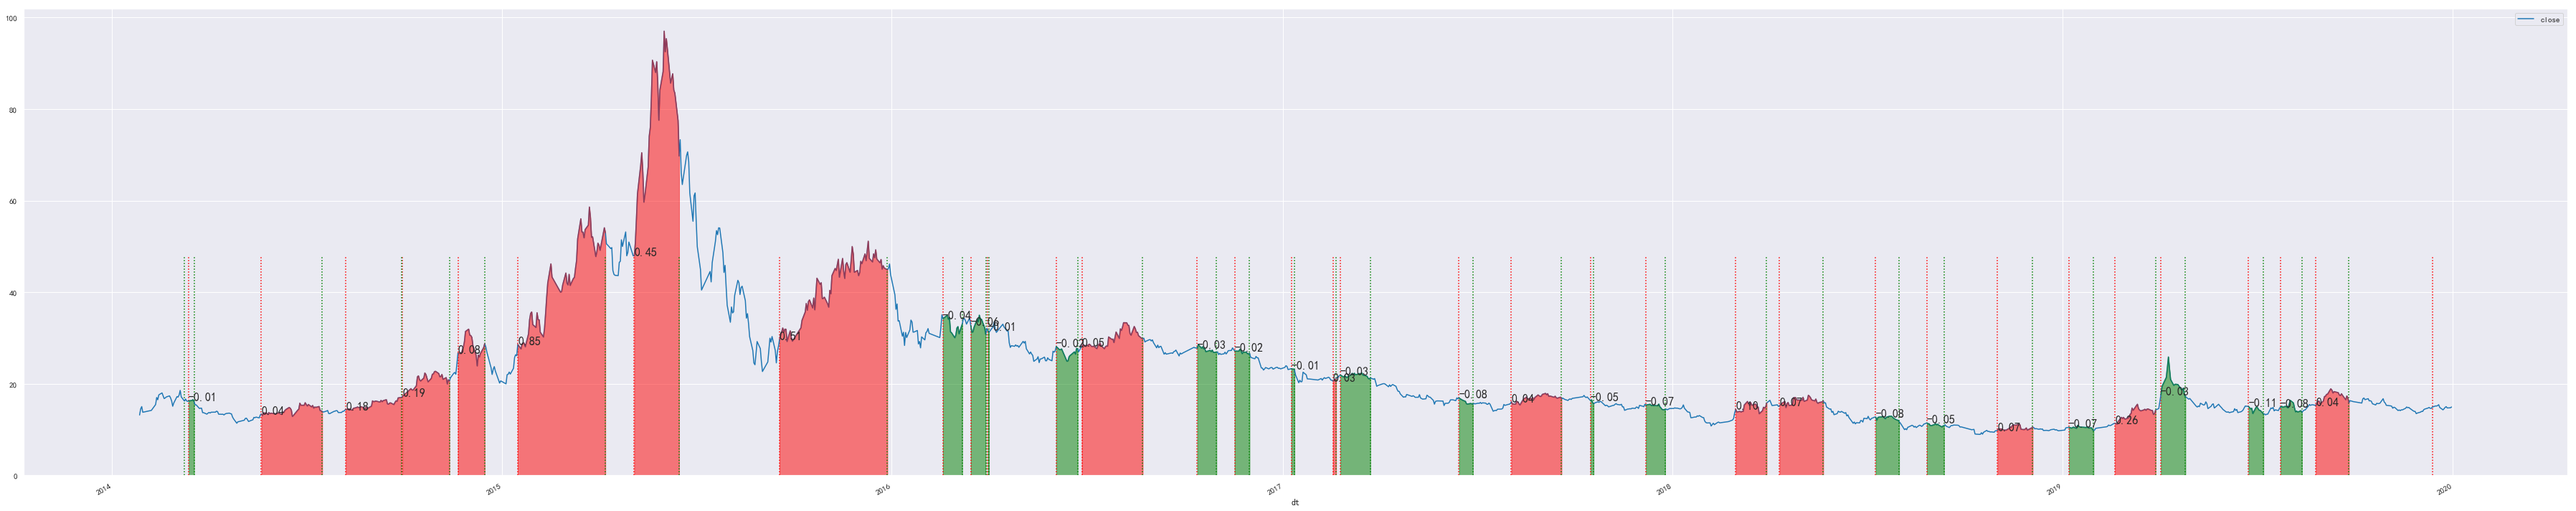

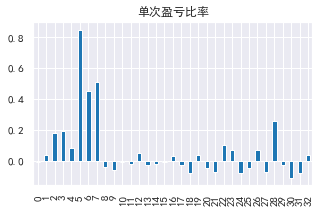

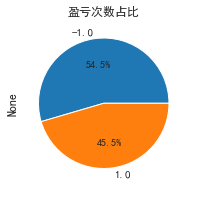

In [11]:
st1=simple_test(simple_data)

In [29]:
st1.name="简单测试-短期均线穿越长期均线（双均线）"
print(st1.to_frame().T.to_markdown())

|                                         |   盈利交易平均盈利比率 |   最大盈利比率 |   亏损交易平均亏损比率 |   最大亏损比率 |   平均盈亏比率 |   交易次数 |   总天数 |   平均持仓天数 |   R(平均利润/平均损失) |
|:----------------------------------------|-----------------------:|---------------:|-----------------------:|---------------:|---------------:|-----------:|---------:|---------------:|-----------------------:|
| 简单测试-短期均线穿越长期均线（双均线） |               0.197792 |         0.8529 |             -0.0469693 |      -0.109115 |      0.0642859 |         33 |     1442 |        20.8485 |                2.25487 |


# 回测

## 仓位控制方法

In [13]:
class Position1(abupy.AbuPositionBase):
    """1手"""
    def _init_self(self, **kwargs):
        """子类仓位管理针对可扩展参数的初始化"""
        pass

    def fit_position(self, factor_object):
        return 100

## 回测方法

In [14]:
def backtest(buy_factors,sell_factors,init_cash=10000,**kwargs):
    start = kwargs.pop('start','2014-01-01')
    end = kwargs.pop('end','2018-12-31')

    benchmark = abupy.AbuBenchmark('000300', start, end)
    # import pdb
    # pdb.set_trace()
    capital = abupy.AbuCapital(init_cash, benchmark)
    klmanager=kwargs.pop('klmanager',KLManager)
    orders_pd, action_pd, _ = abupy.ABuPickTimeExecute.do_symbols_with_same_factors(
        ['300378'],
        benchmark,
        buy_factors,
        sell_factors,
        capital,
        kl_pd_manager=klmanager(benchmark, capital),
        show=False)
    m = gquant.Metrics(orders_pd, action_pd, capital, benchmark)
    m.fit_metrics()
    if hasattr(m, 'act_sell') and not m.act_sell.empty:
        m.act_sell['profit_init']=m.act_sell['profit'] / m.capital.read_cash
        m.act_sell['profit_init_hunder'] = m.act_sell['profit_init'] * 100
        return m
    return None

## 回测结果绘图

In [15]:
def plot_cum_returns(metrics):
    metrics.benchmark_cum_returns.plot()
    metrics.algorithm_cum_returns.plot()
    gquant.plt.legend(['基准收益', '策略收益'], loc='best')
    gquant.plt.title('收益对比')
    gquant.plt.show()

def plot_win_loss_pie(metrics):
    gquant.plt.pie(x=[len(metrics.ret), len(metrics.los)],
                   labels=['盈利', '亏损'],
                   colors=['#d62728', '#2ca02c'],
                   autopct='%1.2f%%')
    gquant.plt.title('盈亏次数比')
    gquant.plt.show()
    
def plot_win_loss_bar(metrics,v='profit_cg_hunder'):
    import matplotlib.ticker
    vc=gquant.np.round(metrics.act_sell[v],0).value_counts().sort_index().to_frame()
    ax=vc.plot(kind='bar',title='盈亏百分比次数')
#     gquant.plt.axvline(x=gquant.np.where(vc.index.to_numpy()==0)[0], color='#d68a27')
#     ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
    gquant.plt.show()
    
def plot_capital_blance(metrics):
    metrics.capital.capital_pd.capital_blance.plot(title='账户价值曲线')
    metrics.capital.capital_pd.cash_blance .plot(title='账户现金曲线')
    gquant.plt.xticks(rotation=70)
    gquant.plt.show()

## 短期均线穿越长期均线（双均线）

- 短期均线(10日)上穿长期均线(20日)（买入）
- 长期均线(20日)上穿短期均线(10日)（卖出）
- 仓位控制：每次买入100股。（[Position1](#%E4%BB%93%E4%BD%8D%E6%8E%A7%E5%88%B6%E6%96%B9%E6%B3%95)）
- 总资金：10000元
- 回测时间段：2014-01-01 ~ 2018-12-31

|                                     |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-短期均线穿越长期均线（双均线） |    6820.67 |    15611.4 |         27 |         15 |         12 |   0.555556 |              207.763 |              454.711 |             -100.922 | 2.06 |  -0.163974 |        2217.06 |

### 数据预处理

In [16]:
class KLManager1(abupy.AbuKLManager):
    def _fetch_pick_time_kl_pd(self, target_symbol):
        data = abupy.MarketBu.ABuSymbolPd.make_kl_df(target_symbol)
        if not data.empty:
            high = data['high']
            low = data['low']
            pre_close = data['pre_close']
            data['atr14'] = calc_atr(high, low, pre_close, 14)
            data['atr21'] = calc_atr(high, low, pre_close, 21)
            for ma in [10,20]:
                data['ma{}'.format(ma)] = SMA(data.close,timeperiod=ma)
            # 短期均线(10日)上穿长期均线(20日)
            data['buy']=QA.QAIndicator.CROSS(data['ma10'],data['ma20'])
            # 长期均线(20日)上穿短期均线(10日)（卖出）
            data['sell']=QA.QAIndicator.CROSS(data['ma20'],data['ma10'])
        result = data[self.benchmark.start:self.benchmark.end]
        result.name = data.name
        return result

### 买卖策略

In [17]:
class BuyStrategy1(gquant.abupy.AbuFactorBuyTD, gquant.abupy.BuyCallMixin):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def fit_day(self, today):
        if today['buy']:
            return self.buy_tomorrow()
        return None
    
class SellStrategy1(gquant.abupy.AbuFactorSellBase):
    def _init_self(self, **kwargs):
        self.factor_name = self.__class__.__name__

    def support_direction(self):
        """支持的方向，只支持正向"""
        return [abupy.ESupportDirection.DIRECTION_CAll.value]

    def fit_day(self, today, orders):
        if today['sell']:
            for order in orders:
                self.sell_tomorrow(order)

In [18]:
# 买入因子
buy_factors = [
    {
        'class': BuyStrategy1,
        # 仓位管理
        'position': {
            'class': Position1
        }
    },
]

# 卖出因子
sell_factors = [{
    'class': SellStrategy1,
}]

bt1 = backtest(buy_factors,sell_factors,klmanager=KLManager1)

Box(children=(Text(value='pid=2276 begin work'), FloatProgress(value=0.0)))

### 结果

In [28]:
print(bt1.profit_series(name='回测-短期均线穿越长期均线（双均线）').to_frame().T.to_markdown())

|                                     |   盈亏总额 |   最终价值 |   交易次数 |   盈利次数 |   亏损次数 |   盈利比率 |   每笔交易平均盈亏额 |   盈利交易平均盈利额 |   亏损交易平均亏损额 |    R |   最大回撤 |   买入平均花费 |
|:------------------------------------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------------------:|---------------------:|---------------------:|-----:|-----------:|---------------:|
| 回测-短期均线穿越长期均线（双均线） |    6820.67 |    15611.4 |         27 |         15 |         12 |   0.555556 |              207.763 |              454.711 |             -100.922 | 2.06 |  -0.163974 |        2217.06 |


### 结果绘图

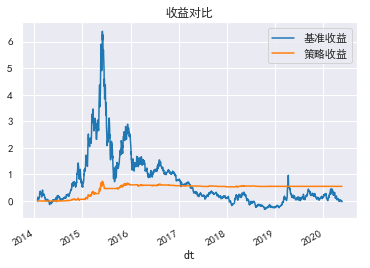

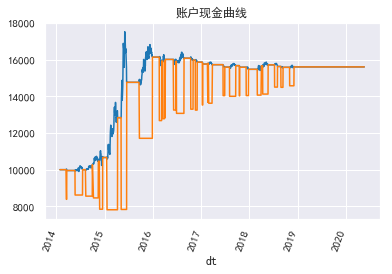

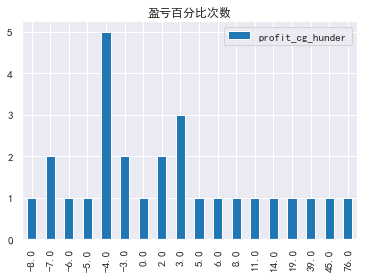

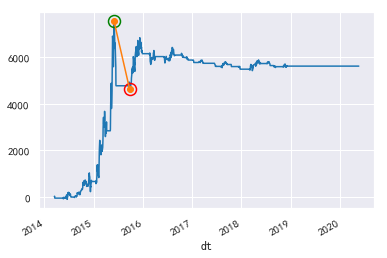

最大回撤: 0.165147
最大回测启始时间:2015-06-02, 结束时间2015-09-25, 共回测2895.355000
策略持股天数平均数: 29.259
策略持股天数中位数: 22.000


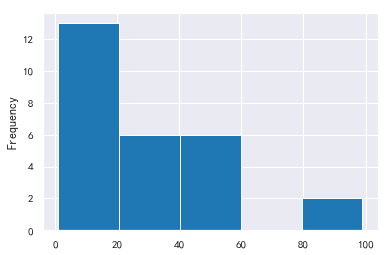

因子平均生效间隔:65.03846153846153


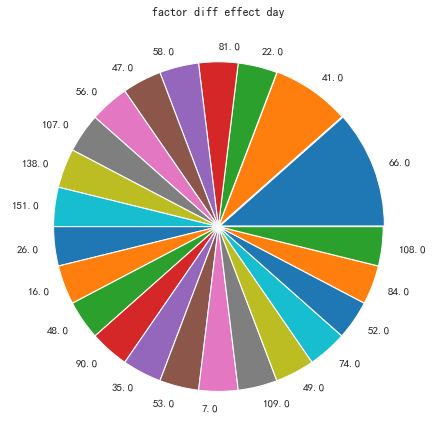

开仓花费情况: 
count:27
max:5005.700195822189
min:1003.4936553937769
mean:2217.0553970537726
std:896.3653453021952
skewness:0.9990004183878964
kurtosis:1.143740902916364


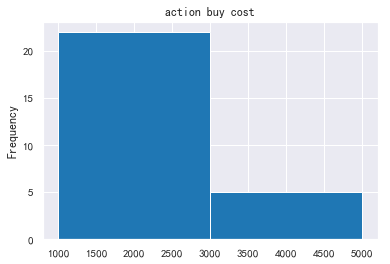

In [20]:
plot_cum_returns(bt1)
plot_capital_blance(bt1)
plot_win_loss_bar(bt1)
bt1.plot_max_draw_down()
bt1.plot_keep_days()
bt1.plot_effect_mean_day()
bt1.plot_action_buy_cost()